In [1]:
import pandas as pd
from path_calc import Solver
from evaluation import Eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from PyComplexHeatmap import *

/home/victo/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
source_df = pd.read_csv('panacea_sources.tsv', sep='\t')

In [3]:
G = nx.read_weighted_edgelist('network_collectri.sif', delimiter = '\t', create_using = nx.DiGraph)
for u, v, data in G.edges(data=True):
    weight = data['weight']
    data['sign'] = 1 if weight >= 0 else -1
    data['weight'] = abs(weight)

In [4]:
def custom_sorting_dict(df, bio_contexts):
    target_dict = {}
    for bio_context in bio_contexts:
        df['abs_values'] = df[bio_context].apply(abs)

        # Sorting the DataFrame based on the temporary column
        df.sort_values(by='abs_values', inplace=True, ascending=False)

        # Dropping the temporary column
        df.drop(columns=['abs_values'], inplace=True)

        bio_context_dict = df[bio_context].to_dict()

        target_dict[bio_context] = bio_context_dict
    
    return target_dict


In [5]:
tf_activities = pd.read_csv('tf_activity_results.tsv', sep='\t', index_col=0).transpose()
bio_contexts = tf_activities.columns.tolist()
tf_dict = custom_sorting_dict(tf_activities, bio_contexts)



In [6]:
nodes_network = [f for f in G.nodes]
filtered_source_df = source_df[source_df.target.isin(nodes_network)]
filtered_source_df

,cmpd,target,sign
0,AEE788,LIMK1,-1
1,AFATINIB,MAPKAPK2,-1
3,BAFETINIB,MAPK14,-1
4,BOSUTINIB,STK10,-1
5,CABOZANTINIB,ABL2,-1
6,CEDIRANIB,DDR2,-1
7,CRENOLANIB,CDK9,-1
8,CRIZOTINIB,PRKD3,-1
9,DACOMITINIB,RIPK2,-1
10,DASATINIB,LIMK2,-1


In [7]:
# create a dictionary per treatment, with the targets as keys and the sign as value
source_dict = {}
for i in range(len(filtered_source_df)):
    treatment = filtered_source_df.iloc[i, 0]
    target = filtered_source_df.iloc[i, 1]
    sign = filtered_source_df.iloc[i, 2]
    if treatment not in source_dict:
        source_dict[treatment] = {}
    source_dict[treatment][target] = float(sign)

source_dict


{'AEE788': {'LIMK1': -1.0},
 'AFATINIB': {'MAPKAPK2': -1.0},
 'BAFETINIB': {'MAPK14': -1.0},
 'BOSUTINIB': {'STK10': -1.0},
 'CABOZANTINIB': {'ABL2': -1.0},
 'CEDIRANIB': {'DDR2': -1.0},
 'CRENOLANIB': {'CDK9': -1.0},
 'CRIZOTINIB': {'PRKD3': -1.0},
 'DACOMITINIB': {'RIPK2': -1.0},
 'DASATINIB': {'LIMK2': -1.0},
 'DOVITINIB': {'MARK4': -1.0},
 'FORETINIB': {'EPHA4': -1.0},
 'GEFITINIB': {'GAK': -1.0},
 'ICOTINIB': {'GAK': -1.0},
 'IMATINIB': {'DDR2': -1.0},
 'KW2449': {'MAP4K2': -1.0},
 'LAPATINIB': {'EGFR': -1.0},
 'LINIFANIB': {'FLT3': -1.0},
 'MGCD265': {'PTK6': -1.0},
 'MK2206': {'AKT3': -1.0},
 'NERATINIB': {'STK26': -1.0},
 'NILOTINIB': {'MAPK14': -1.0},
 'OSIMERTINIB': {'BTK': -1.0},
 'PONATINIB': {'MAP4K1': -1.0},
 'QUIZARTINIB': {'MYH10': -1.0},
 'REGORAFENIB': {'EPHA2': -1.0},
 'SUNITINIB': {'CLK2': -1.0},
 'TIVANTINIB': {'MET': -1.0},
 'VANDETANIB': {'BCR': -1.0},
 'VARLITINIB': {'RIPK2': -1.0}}

In [251]:
for bio_context in bio_contexts:
    print('Solving for cell line and drug {}'.format(bio_context))    
    G_solver = Solver(G, 'PANACEA')
    cell_line, drug = bio_context.split('_')
    try:
        G_solver.source_dict = source_dict[drug]
    except KeyError:
        print('No sources for drug {}'.format(drug))
        continue
    G_solver.network_batchrun(iter = bio_context, tf_dict = target_dict, cutoff = 6)


Solving for cell line and drug ASPC_AFATINIB


KeyError: 'ASPC_AFATINIB'

In [9]:
import itertools
targets_retriever = Solver(G, 'PANACEA')
filtered_tf_dict = {}
for iter in bio_contexts:
    cell_line, drug = iter.split('_')
    try:
        targets_retriever.source_dict = source_dict[drug]
    except KeyError:
        print('No sources for drug {}'.format(drug))
        continue
    targets_retriever.label = f'{targets_retriever.study_id}__{iter}'
    targets_retriever.iter = iter
    targets_retriever.subG = targets_retriever.reachability_filter(targets_retriever.G)
    nodes = [node for node in targets_retriever.subG.nodes()]

    # subset the dict to only include nodes in the subG
    tf_subset = tf_dict[iter]
    target_dict = {k: v for k, v in tf_subset.items() if k in nodes}
    # get the first 50 elements of the dict
    target_dict_top50 = dict(itertools.islice(target_dict.items(), 50))
    filtered_tf_dict[iter] = target_dict_top50

No sources for drug AZD5363
No sources for drug SORAFENIB
No sources for drug SORAFENIB


In [10]:
filtered_tf_dict

{'ASPC_AFATINIB': {'SP3': 3.4767413,
  'EWSR1': 2.8178358,
  'FOSB': 2.8110776,
  'SMARCC1': -2.6329894,
  'SFPQ': -2.6205943,
  'PHF20': 2.6141043,
  'HIF1A': 2.404955,
  'TP73': 2.3658614,
  'NFKB1': 2.3438237,
  'NR1H4': 2.3382044,
  'TBX3': -2.3113658,
  'HDAC9': -2.307067,
  'GABPA': 2.2617137,
  'STAT4': 2.251217,
  'STAT2': 2.2378714,
  'FOS': 2.2068725,
  'SP1': 2.206204,
  'MEF2D': 2.164318,
  'NR1D1': -2.1292727,
  'TP63': 2.060135,
  'GLI2': -2.0358262,
  'RUNX1': 2.0267584,
  'USF1': 2.0140905,
  'HNF4A': 1.996379,
  'NR5A1': 1.9955176,
  'MAX': -1.9935031,
  'RELA': 1.9838567,
  'GTF2I': -1.9370046,
  'EP300': 1.9086915,
  'STAT3': 1.8759804,
  'TWIST1': -1.846314,
  'EGR1': 1.7883898,
  'GATA1': 1.7660046,
  'IRF3': 1.7587569,
  'POU2F1': 1.7520763,
  'BHLHE40': -1.746381,
  'SREBF2': 1.7197665,
  'DDIT3': 1.712364,
  'NCOA2': 1.6776605,
  'MYF5': 1.6750077,
  'CTBP1': 1.6576647,
  'TAL1': 1.6242689,
  'NFATC3': 1.6149105,
  'HNF1A': 1.6134822,
  'MYB': -1.5995948,
  'SNA

In [253]:
import pandas as pd
import os
import networkx as nx
import ptitprince as pt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from path_calc import Solver    
import umap
import matplotlib.pyplot as plt

class Eval:
    def __init__(self, G, tf_dict, dirpath, study_id):
        self.dirpath = dirpath
        self.G = G
        self.study_id = study_id
        self.target_dict = tf_dict
        self.tests_dict = self.get_test_dict()
        self.graphs, self.graphdata_df = self.parse_sif_files()
        self.distance_df = None
        self.filtered_df = None
        __super__ = Solver

    def get_datafiles(self):
        files_list = os.listdir(self.dirpath)
        sif_files = [os.path.join(self.dirpath, f) for f in files_list if (f.endswith('.sif') and (self.study_id in f))]
        return sif_files
    
    def get_test_dict(self):
        filename = f'./{self.study_id}__testtargets.csv'
        try:
            df = pd.read_csv(filename, index_col=0)
            data_dict = df.to_dict()
            for key in data_dict:
                data_dict[key] = {k: v for k, v in data_dict[key].items() if pd.notna(v)}
            
            return data_dict
        
        except FileNotFoundError:
            
            return f"File {filename} not found."

    def parse_sif_files(self):
        """
        Parse a list of SIF files, return a dictionary of networkx graphs, and extract metadata with ordered methods.
        
        Parameters:
        - file_paths (list): List of paths to the SIF files.
        
        Returns:
        - dict: Dictionary where keys are filenames (without .sif extension) and values are networkx graphs.
        - DataFrame: Metadata dataframe with study ID, methods, pagerank threshold, and original graph ID columns.
        """
        graphs = {}
        
        # Lists to store the metadata
        graph_ids = []
        study_ids = []
        iter_ids = []
        methods_list = []
        pagerank_thresholds = []

        file_paths = self.get_datafiles()
        
        for file_path in file_paths:
            # Extract the filename without the .sif extension
            graph_id = file_path.split('/')[-1].replace('.sif', '')
            
            # Store the original graph ID
            graph_ids.append(graph_id)
            
            # Initialize a directed graph
            G = nx.DiGraph()
            
            # Parse the SIF file, skipping the header
            with open(file_path, 'r') as f:
                lines = f.readlines()[1:]  # skip the header
                for line in lines:
                    parts = line.strip().split('\t')
                    if len(parts) == 3:
                        source, interaction, target = parts
                        interaction = 1 if interaction == 'P' else (-1 if interaction == 'N' else interaction)
                        G.add_edge(source, target, interaction=interaction)
            
            # Store the graph in the dictionary
            graphs[graph_id] = G
            
            # Metadata extraction
            parts = graph_id.split('__')
            study_ids.append(parts[0])
            iter_ids.append(parts[1])
            
            method_parts = parts[2:]
            pagerank_value = None
            for idx, part in enumerate(method_parts):
                if "pagerank" in part:
                    pagerank_value = float(part.split('_')[-1])  # Extract float value after "pagerank_"
                    method_parts[idx] = "pagerank"  # Replace with "pagerank" string
            
            pagerank_thresholds.append(pagerank_value)
            methods_list.append(', '.join(method_parts))
        
        # Create the metadata dataframe
        metadata_df = pd.DataFrame({
            'Graph ID': graph_ids,
            'Study ID': study_ids,
            'Iteration': iter_ids,
            'Methods': methods_list,
            'Pagerank Threshold': pagerank_thresholds
        })

        metadata_df.sort_values(by=['Study ID', 'Iteration', 'Methods', 'Pagerank Threshold'], inplace=True)
        
        return graphs, metadata_df
    

    # Distance eval
    def distance_calc(self):
        distances = []
        test_nodes = []
        network_nodes = []
        graph_ids = []
        run_ids = []
        undirG = self.G.reverse()
        for graph in self.graphs:
            run = graph.strip().split('__')[1]
            nodes_subnetwork = [node for node in self.graphs[graph].nodes]
            for node in nodes_subnetwork:
                for test_node in self.tests_dict[run]:
                    try:
                        distance = nx.shortest_path_length(undirG, source=test_node, target=node)
                    except nx.NetworkXNoPath:
                        distance = np.Inf
                    distances.append(distance)
                    test_nodes.append(test_node)
                    network_nodes.append(node)
                    graph_ids.append(graph)
                    run_ids.append(run)
        
        self.distance_df = pd.DataFrame({
            'Graph ID': graph_ids,
            'Run ID': run_ids,
            'Study ID': self.study_id,
            'Test nodes': test_nodes,
            'Network nodes': network_nodes,
            'Distances': distances
        })

        self.plot_distance(self.distance_df)
        
        return self.distance_df
    
    def plot_distance(self, distances_df):
        distances_df["Main Method"] = distances_df["Graph ID"].apply(lambda x: x.split("__")[2].split('_pagerank')[0])
        plt.figure(figsize=(15, 10))
        
        # Creating a color palette for pagerank thresholds
        unique_thresholds = distances_df["Graph ID"].apply(lambda x: x.split('_')[-1]).unique()
        color_palette = dict(zip(unique_thresholds, sns.color_palette("rainbow", len(unique_thresholds))))
        
        # Boxplot
        sns.boxplot(data=distances_df, x="Main Method", y="Distances", hue="Graph ID", palette=color_palette, dodge=True)
        
        # Adjusting the plot aesthetics
        plt.xticks(rotation=45)
        plt.legend(title="Pagerank Threshold", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.tight_layout()
        
        plt.show()

    # Comparisons
    def get_number_nodes(self):
        """
        For a given dictionary of networks, computes the number of nodes and appends it to the self.graphdata_df dataframe.
        """
        num_nodes = []
        for graph in self.graphs:
            num_nodes.append(len(self.graphs[graph].nodes))
        nodes_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Number of nodes': num_nodes})
        self.graphdata_df = pd.merge(self.graphdata_df, nodes_info, on="Graph ID")
    
    def get_number_edges(self):
        num_edges = []
        for graph in self.graphs:
            num_edges.append(len(self.graphs[graph].edges))
        edges_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Number of edges': num_edges})
        self.graphdata_df = pd.merge(self.graphdata_df, edges_info, on="Graph ID")

    def get_connected_targets(self):
        """
        Given a network and a set of targets, compute how many targets are in the network (nodes)
        """
        num_targets = []
        for graph in self.graphs:
            iter_id = graph.split('__')[1]
            targets = self.target_dict[iter_id].keys()
            num_targets.append(len(set(targets) & set(self.graphs[graph].nodes)))
        targets_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Connected targets': num_targets})
        self.graphdata_df = pd.merge(self.graphdata_df, targets_info, on="Graph ID")

    def compute_degree_distribution(self):
        """
        Compute the degree distribution for each graph in the self.graphs dictionary.
        """
        degree_distributions = []
        for graph in self.graphs:
            degree_distributions.append(self.graphs[graph].degree)
        degree_info = pd.DataFrame({'Graph ID': list(self.graphs.keys()), 'Degree distribution': degree_distributions})
        self.graphdata_df = pd.merge(self.graphdata_df, degree_info, on="Graph ID")

    def find_elbow(self, x, y):
        """
        Find the elbow of a curve using x and y coordinates.

        Args:
            x (list): List of x coordinates.
            y (list): List of y coordinates.

        Returns:
            int: Index of the elbow point.
        """
        # Coordinates of the first point
        p1 = np.array([x[0], y[0]])
        
        # Coordinates of the last point
        p2 = np.array([x[-1], y[-1]])
        
        
        # Find the elbow by computing distance from each point to the line
        distances = []
        for i in range(len(x)):
            point = np.array([x[i], y[i]])
            distance = np.linalg.norm(np.cross(p2-p1, p1-point))/np.linalg.norm(p2-p1)
            distances.append(distance)
            
        # Return the index of the point with max distance which is the elbow
        return np.argmax(distances)
    
    def threshold_filter(self):
        perc_missing_targets = []
        num_edges = []

        methods = set(self.graphdata_df['Methods'].tolist())
        iterations = set(self.graphdata_df['Iteration'].tolist())
        filtered_df = pd.DataFrame()
        print(self.target_dict)

        for iterat in iterations:
            for method in methods:
                drug = iterat.split('_')[1]
                cell_line = iterat.split('_')[0]
                print(f"Processing {method} {iterat}...")
                sorted_df = self.graphdata_df[(self.graphdata_df['Methods'] == method) & (self.graphdata_df['Iteration'] == iterat)].sort_values(by=['Pagerank Threshold'])

                targets = self.target_dict[iterat].keys()
                num_targets = len(targets)
                print(num_targets)
                # add column of missing targets
                sorted_df['Perc missing targets'] = (num_targets - sorted_df['Connected targets']) / num_targets * 100

                perc_missing_targets = sorted_df['Perc missing targets'].tolist()
                num_edges = sorted_df['Number of edges'].tolist()
                
                selected_threshold_index = self.find_elbow(num_edges, perc_missing_targets)
                # bind rows the selected threshold to the filtered df using pd.concat
                threshold_100 = sorted_df[sorted_df['Pagerank Threshold'] == 100]
                filtered_df = pd.concat([filtered_df, sorted_df.iloc[selected_threshold_index:selected_threshold_index+1, :], threshold_100])
        
        
        filtered_df = filtered_df[~((filtered_df['Pagerank Threshold'] == 100) & (filtered_df['Methods'].str.contains('reachability, pagerank, reachability, allpaths')))]
        
        filtered_df.loc[filtered_df['Pagerank Threshold'] == 100, 'Methods'] = filtered_df['Methods'].apply(lambda x: x.replace('pagerank, ', ''))
        filtered_df['cell_line'] = filtered_df['Iteration'].apply(lambda x: x.split('_')[0]).tolist()
        filtered_df['drug'] = filtered_df['Iteration'].apply(lambda x: x.split('_')[1]).tolist()

        
        self.graphdata_df = filtered_df
    
    def get_returned_offtargets(self, offtarget_dict):
        offtarget_results = []

        # Iterating over each key in the network dictionary
        for key, graph in self.graphs.items():
            # Iterating over each drug and its targets in the drug_target_dict
            for drug, targets in offtarget_dict.items():
                # Checking if the drug name is present in the key
                if drug.lower() in key.lower():
                    # Counting how many targets are present in the nodes of the network
                    target_count = sum(1 for target in targets if target in graph.nodes)
                    all_offtargets = len(targets)
                    perc_offtargets = (target_count / len(targets)) * 100
                    # Appending the results to the list
                    offtarget_results.append({'Graph ID': key, 'offtarget_count': target_count, 'all_offtargets': all_offtargets, 'perc_offtarget': perc_offtargets})

        # Creating a DataFrame from the results list
        offtarget_result_df = pd.DataFrame(offtarget_results)
        self.graphdata_df = pd.merge(self.graphdata_df, offtarget_result_df, on="Graph ID")
        
    def compute_overlap(self, iter):
        subset_df = self.graphdata_df[self.graphdata_df['Iteration'] == iter]
        print(subset_df)
    
    def degree_centrality(self):
        degree_centrality = []

        for graph in self.graphs:
            degree_results = nx.degree_centrality(self.graphs[graph])
            degree_centrality.append({'Graph ID': graph, 
                                      'Degree centrality': degree_results, 
                                      'Mean degree centrality': np.mean(list(degree_results.values()))})




        degree_centrality_df = pd.DataFrame(degree_centrality)
        self.graphdata_df = pd.merge(self.graphdata_df, degree_centrality_df, on="Graph ID")


    def closeness_centrality(self):
        closeness_centrality = []

        for graph in self.graphs:
            closeness_results = nx.closeness_centrality(self.graphs[graph])
            closeness_centrality.append({'Graph ID': graph, 
                                         'Closeness centrality': closeness_results, 
                                         'Mean closeness centrality': np.mean(list(closeness_results.values()))})
        closeness_centrality_df = pd.DataFrame(closeness_centrality)
        self.graphdata_df = pd.merge(self.graphdata_df, closeness_centrality_df, on="Graph ID")
    
    def betweenness_centrality(self):
        betweenness_centrality = []

        for graph in self.graphs:
            betweenness_results = nx.betweenness_centrality(self.graphs[graph])
            betweenness_centrality.append({'Graph ID': graph, 
                                           'Betweenness centrality': betweenness_results,
                                           'Mean betweenness centrality': np.mean(list(betweenness_results.values()))})
        betweenness_centrality_df = pd.DataFrame(betweenness_centrality)
        self.graphdata_df = pd.merge(self.graphdata_df, betweenness_centrality_df, on="Graph ID")
    
    def compute_centrality_metrics(self):
        print('Computing degree centrality')
        self.degree_centrality()
        print('Computing closeness centrality')
        self.closeness_centrality()
        print('Computing betweenness centrality')
        self.betweenness_centrality()

    def create_edge_matrix(self):
        """
        Creates a binary matrix representing the presence or absence of edges in each graph.
        
        Parameters:
        - graph_dict: dictionary
            Keys are graph IDs and values are NetworkX graphs.
        
        Returns:
        - pandas DataFrame
            Rows represent edges, columns represent graphs, values are binary.
        """
        # Extract all unique edges from all graphs
        all_edges = set()
        graph_ids = self.graphdata_df['Graph ID'].tolist()
        #get only graphs present in the graph ids list
        graph_dict = {k: v for k, v in self.graphs.items() if k in graph_ids}
        for graph in graph_dict.values():
            all_edges.update(graph.edges)
        
        # Sort edges for consistent ordering
        all_edges = sorted(all_edges)
        
        # Create the matrix
        matrix_data = []
        for edge in all_edges:
            row = []
            for graph_id, graph in graph_dict.items():
                row.append(1 if graph.has_edge(*edge) else 0)
            matrix_data.append(row)
        
        # Create DataFrame
        columns = list(graph_dict.keys())
        edge_matrix = pd.DataFrame(matrix_data, columns=columns, index=all_edges)
        
        return edge_matrix
    
    def plot_umap(self, features):
        edge_matrix = self.create_edge_matrix()
        edge_metric_columns = edge_matrix.columns.tolist()
        filtered_rundf = self.graphdata_df
        # set Graph ID as index
        filtered_rundf = filtered_rundf.set_index('Graph ID')
        # sort the filtered_rundf by the order of the edge metric column ids and the Graph ID column from the filtered_rundf
        filtered_rundf = filtered_rundf.reindex(index=edge_metric_columns)
        # Applying UMAP to the edge matrix
        reducer = umap.UMAP()
        embedding = reducer.fit(edge_matrix.transpose())

        for feature in features:
            umap.plot.points(embedding, labels=filtered_rundf[feature])
    
    def plot_raincloud_plots(self, feature):
        plt.figure(figsize=(15, 10))
        ax = pt.RainCloud(data = self.graphdata_df, x = 'Methods', y = feature, palette = "Set2",
                            orient = 'h', width_box= .1, width_viol=1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')

        plt.show()


In [11]:
offtargets_df = pd.read_csv('panacea_offtargets.tsv', sep='\t')
offtarget_dict = {}

# Iterate over each row in the DataFrame
for index, row in offtargets_df.iterrows():
    # Get the drug and target from the row
    drug = row['cmpd']
    target = row['target']
    
    # Check if the drug is already a key in the dictionary
    if drug in offtarget_dict:
        # If it is, append the target to the list of targets for that drug
        offtarget_dict[drug].append(target)
    else:
        # If it isn’t, create a new list with the target and assign it to the drug key
        offtarget_dict[drug] = [target]



In [12]:
from evaluation import Eval
G1_eval = Eval(G, filtered_tf_dict, './results/', 'PANACEA')


In [13]:
G1_eval.get_number_nodes()
G1_eval.get_number_edges()
G1_eval.get_connected_targets()
G1_eval.threshold_filter()
G1_eval.compute_centrality_metrics()
G1_eval.get_returned_offtargets(offtarget_dict)

{'ASPC_AFATINIB': {'SP3': 3.4767413, 'EWSR1': 2.8178358, 'FOSB': 2.8110776, 'SMARCC1': -2.6329894, 'SFPQ': -2.6205943, 'PHF20': 2.6141043, 'HIF1A': 2.404955, 'TP73': 2.3658614, 'NFKB1': 2.3438237, 'NR1H4': 2.3382044, 'TBX3': -2.3113658, 'HDAC9': -2.307067, 'GABPA': 2.2617137, 'STAT4': 2.251217, 'STAT2': 2.2378714, 'FOS': 2.2068725, 'SP1': 2.206204, 'MEF2D': 2.164318, 'NR1D1': -2.1292727, 'TP63': 2.060135, 'GLI2': -2.0358262, 'RUNX1': 2.0267584, 'USF1': 2.0140905, 'HNF4A': 1.996379, 'NR5A1': 1.9955176, 'MAX': -1.9935031, 'RELA': 1.9838567, 'GTF2I': -1.9370046, 'EP300': 1.9086915, 'STAT3': 1.8759804, 'TWIST1': -1.846314, 'EGR1': 1.7883898, 'GATA1': 1.7660046, 'IRF3': 1.7587569, 'POU2F1': 1.7520763, 'BHLHE40': -1.746381, 'SREBF2': 1.7197665, 'DDIT3': 1.712364, 'NCOA2': 1.6776605, 'MYF5': 1.6750077, 'CTBP1': 1.6576647, 'TAL1': 1.6242689, 'NFATC3': 1.6149105, 'HNF1A': 1.6134822, 'MYB': -1.5995948, 'SNAI1': 1.5626906, 'BMAL1': 1.5356605, 'CLOCK': 1.510754, 'HBP1': 1.4843208, 'IRF4': 1.472469

/home/victo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Computing closeness centrality


/home/victo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Computing betweenness centrality


/home/victo/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/victo/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


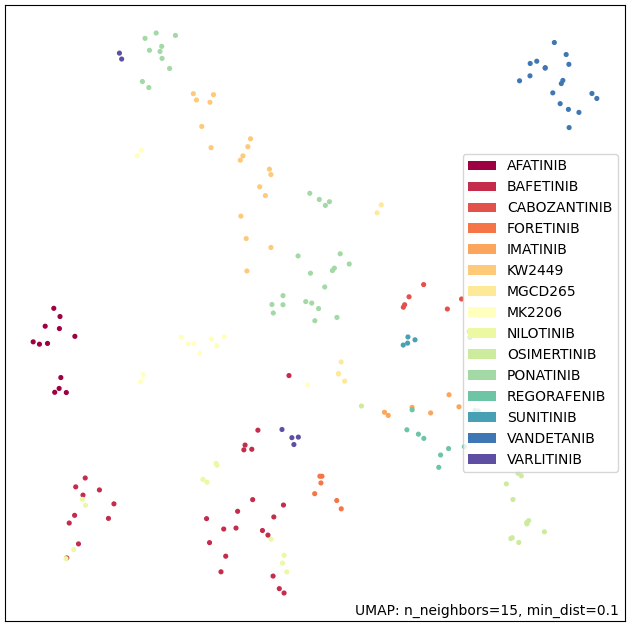

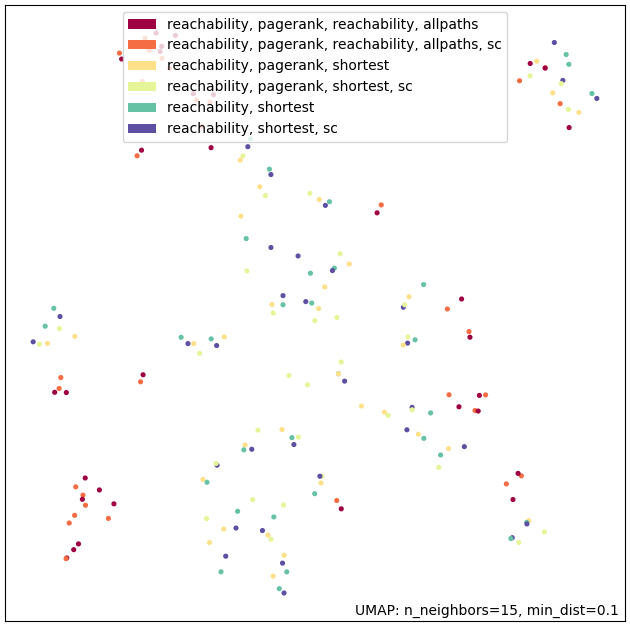

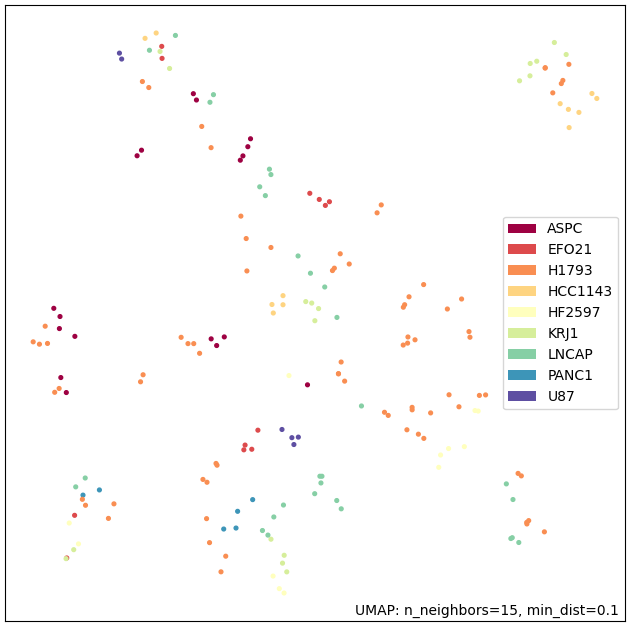

In [257]:
G1_eval.plot_umap(['drug', 'Methods', 'cell_line'])

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


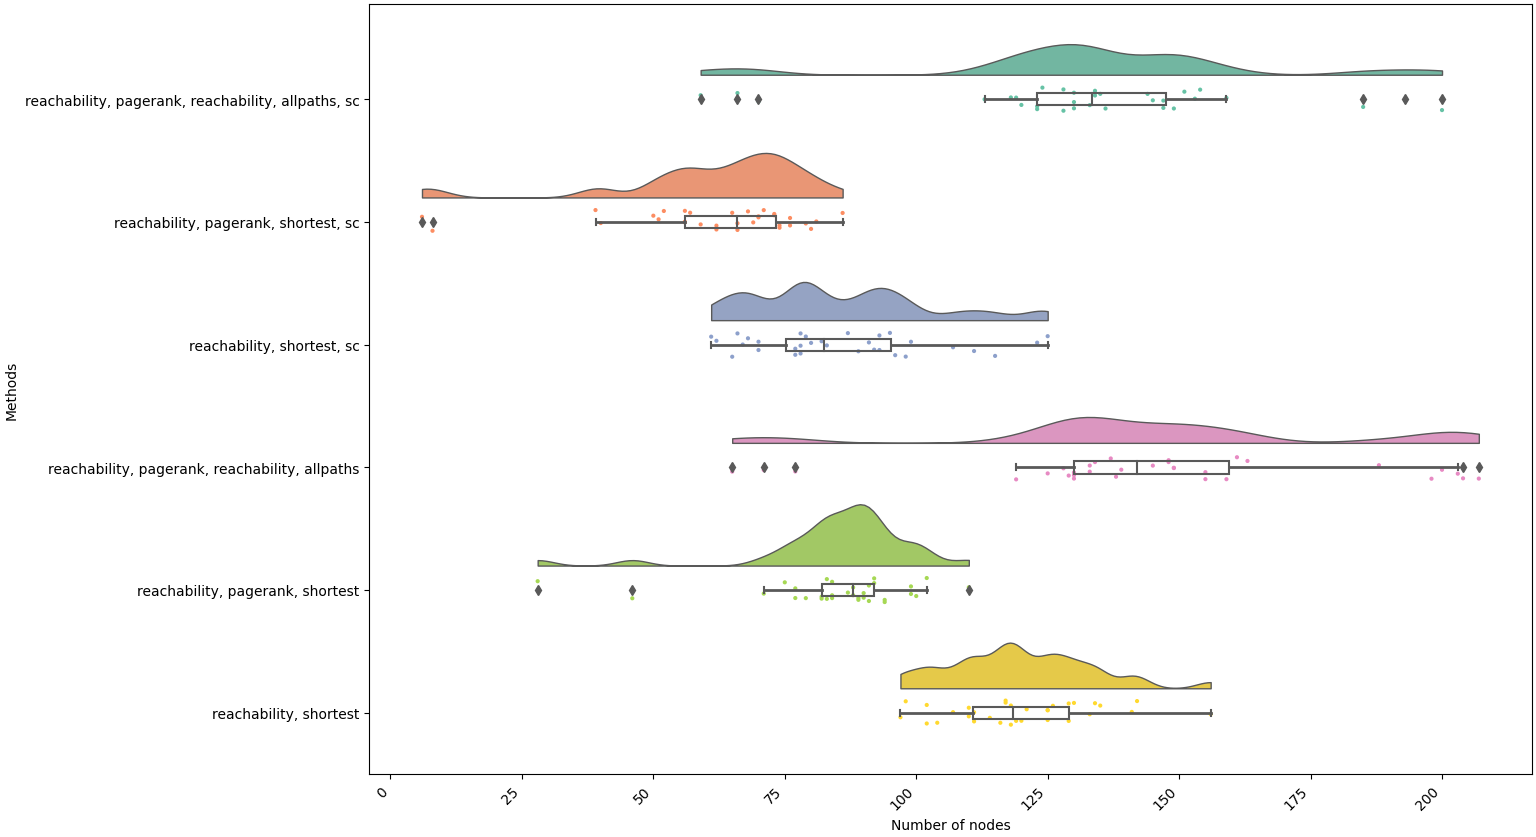

In [14]:
G1_eval.plot_raincloud_plots('Number of nodes')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


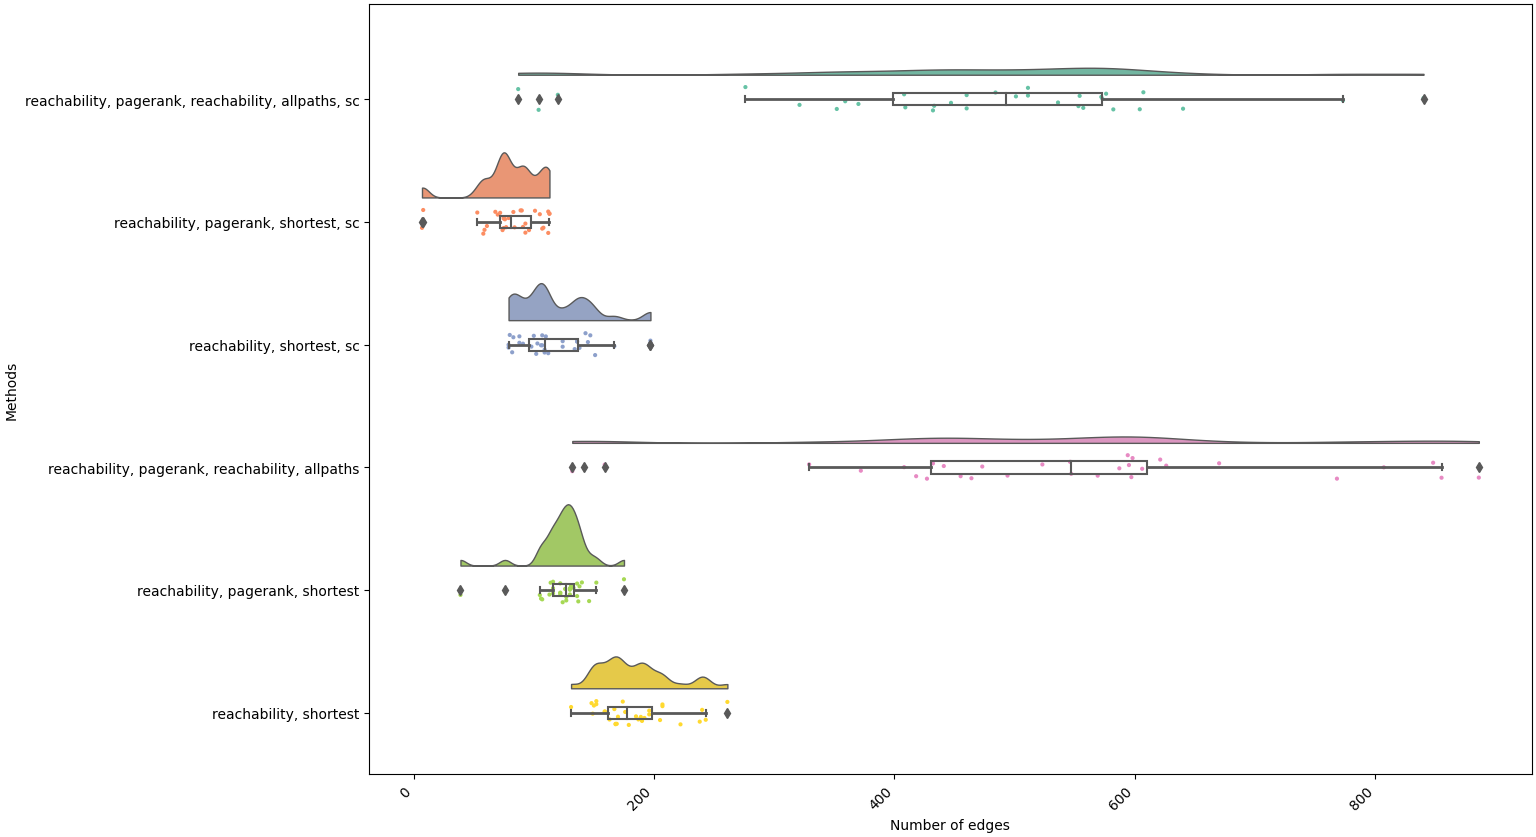

In [15]:
G1_eval.plot_raincloud_plots('Number of edges')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


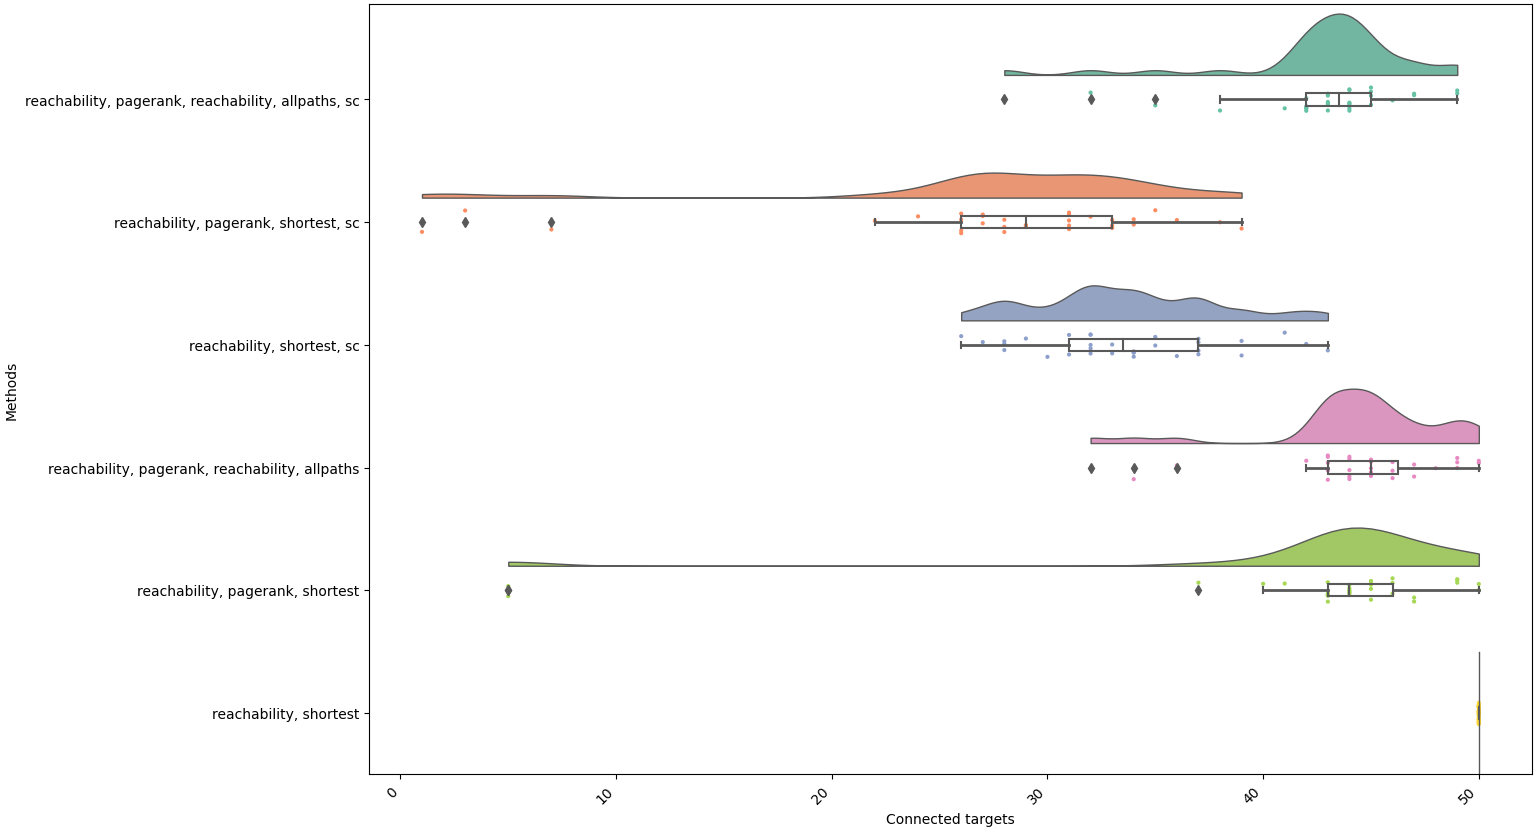

In [16]:
G1_eval.plot_raincloud_plots('Connected targets')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


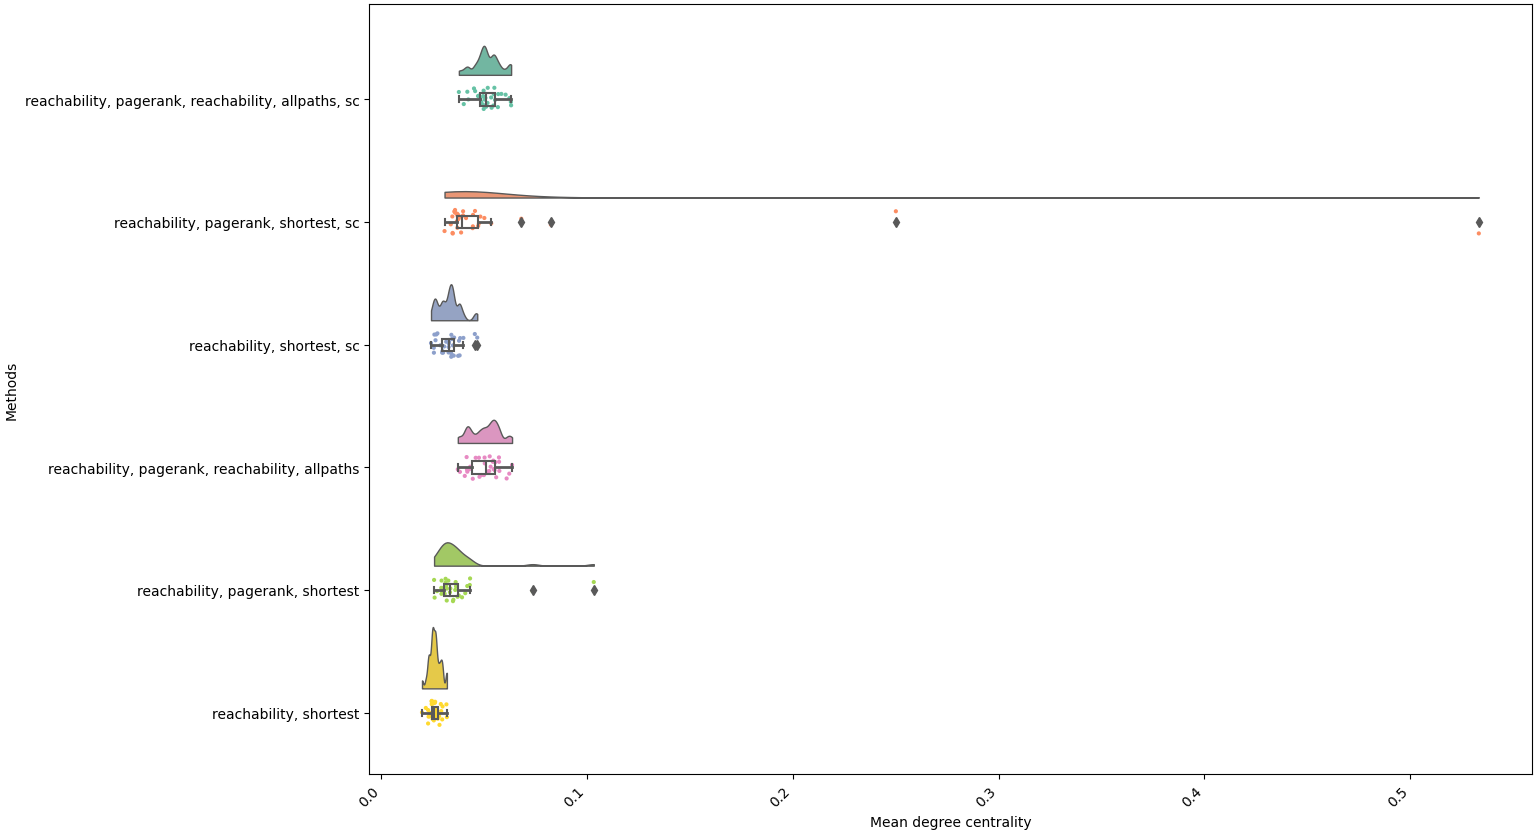

In [17]:
G1_eval.plot_raincloud_plots('Mean degree centrality')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


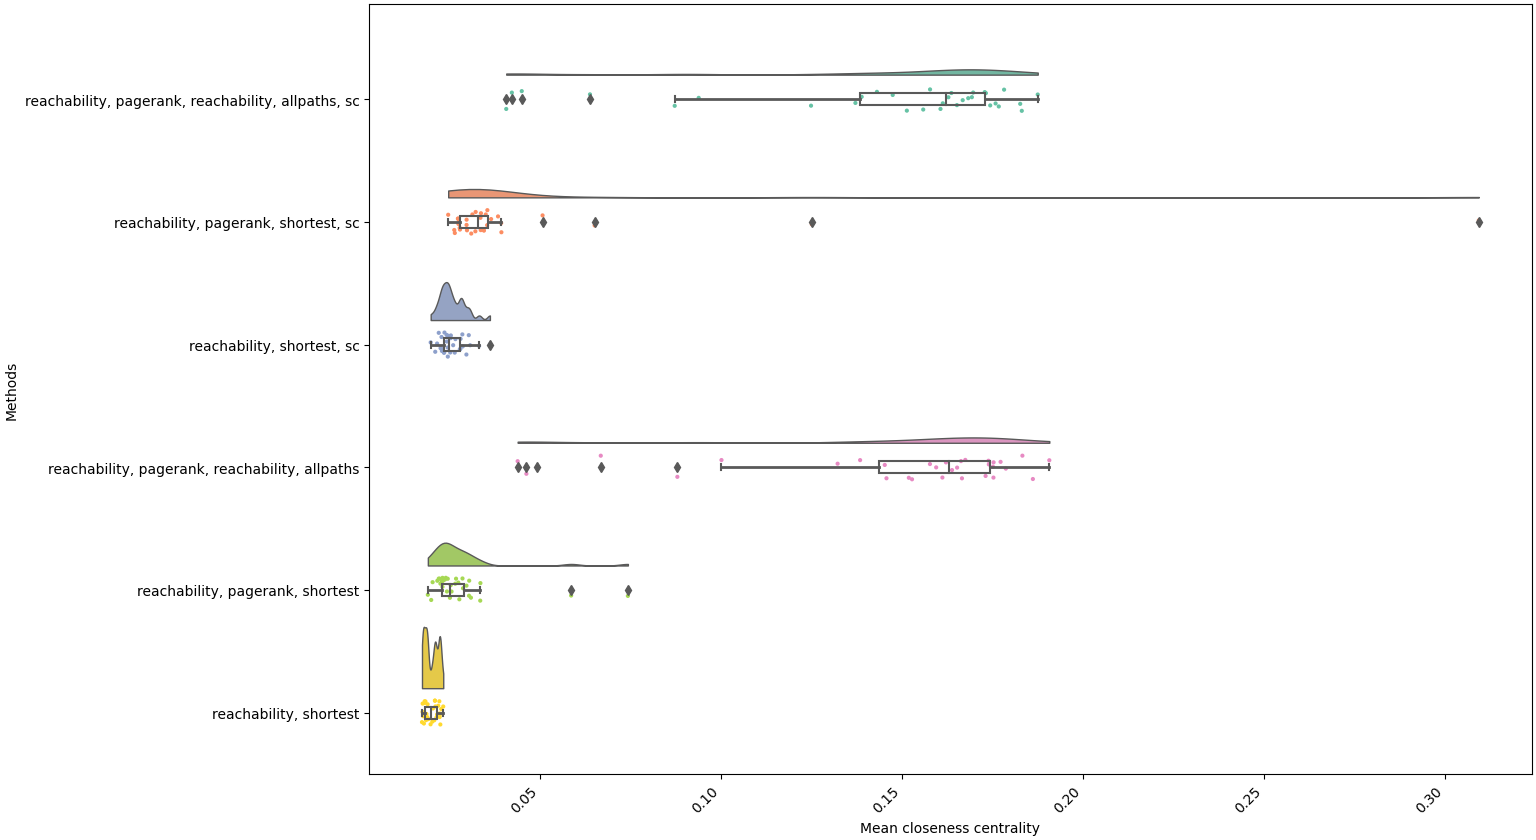

In [18]:
G1_eval.plot_raincloud_plots('Mean closeness centrality')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


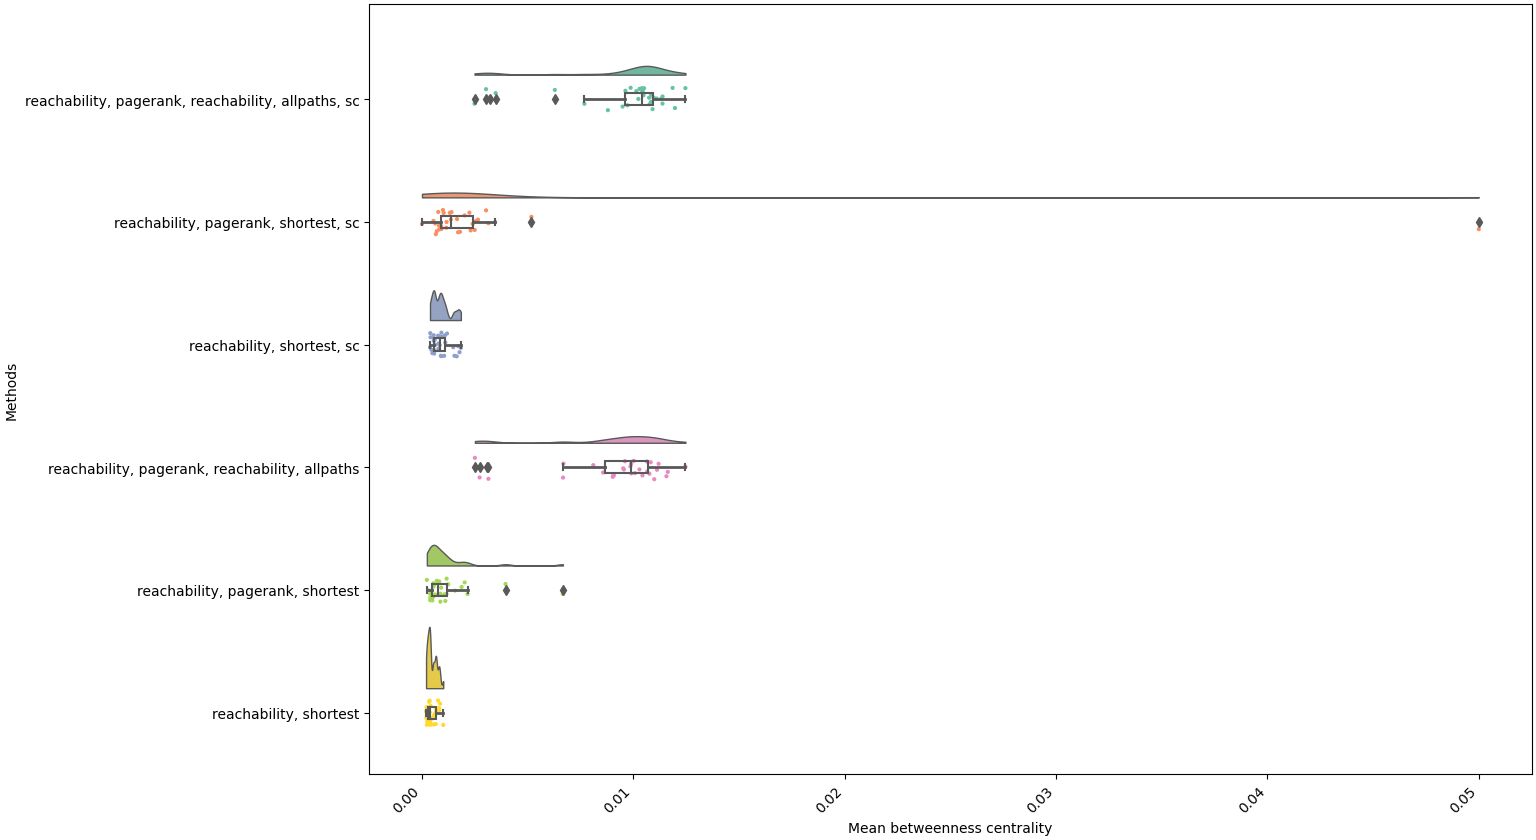

In [19]:
G1_eval.plot_raincloud_plots('Mean betweenness centrality')

/home/victo/tfm/vp-mthesis/evaluation.py:406: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  ha='right')


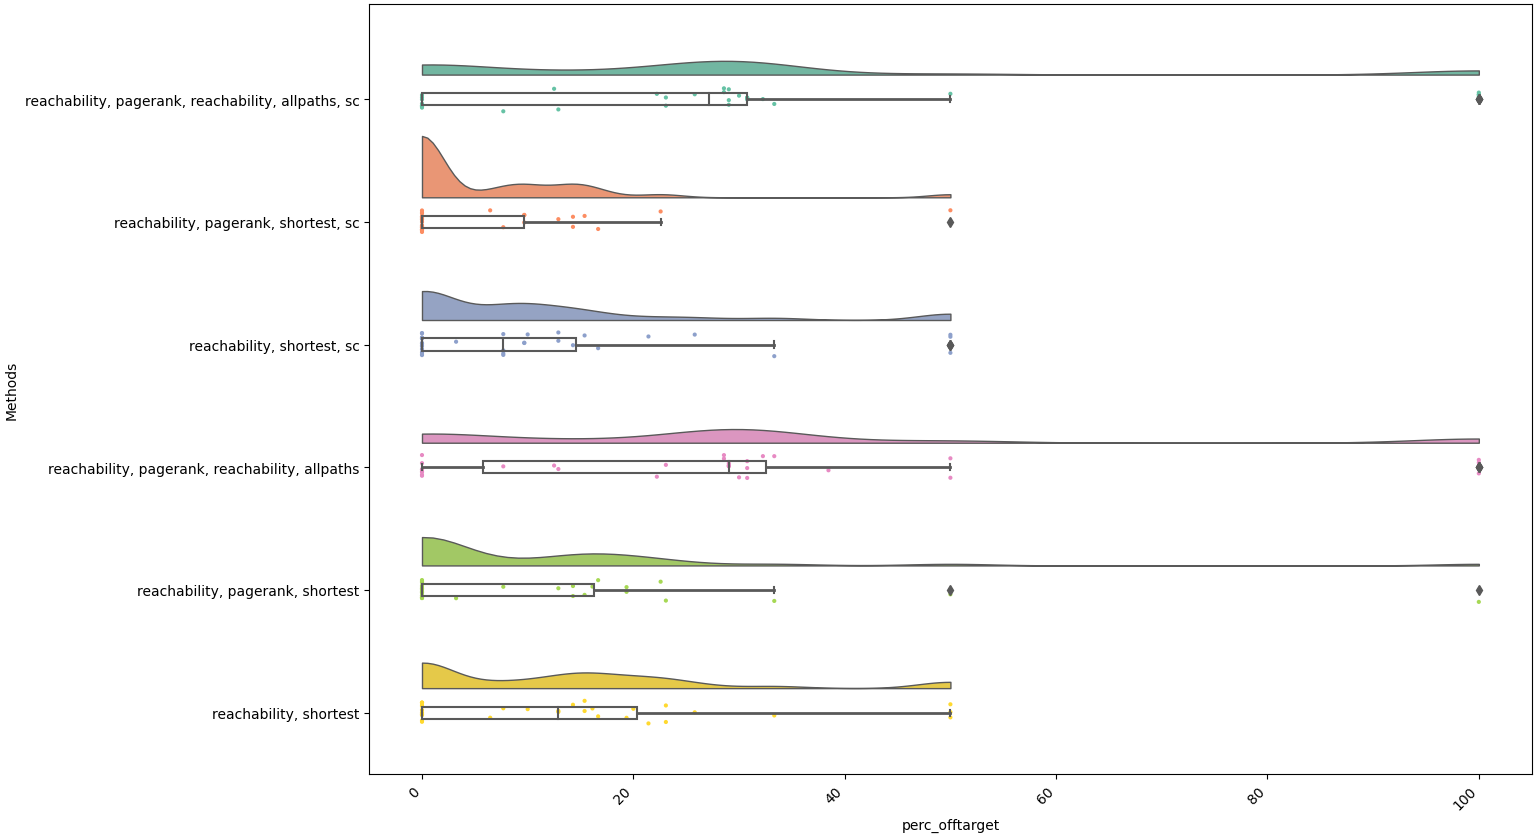

In [20]:
G1_eval.plot_raincloud_plots('perc_offtarget')

In [21]:
G1_eval.graphdata_df.to_csv('panacea_filtered_runresults.tsv', sep='\t', index=False)

In [32]:
nodes_df = filtered_rundf[['Graph ID', 'Iteration', 'Methods', 'Number of nodes', 'cell_line', 'drug']]
# combine methods and cell line column
nodes_df['Method_cell_line'] = nodes_df['Methods'] + '; ' + nodes_df['cell_line']
# pivot wider: method_cell_line as columns, drug as index, number of nodes as values
nodes_df = nodes_df.pivot_table(index='drug', columns='Method_cell_line', values='Number of nodes')
nodes_df.fillna(0, inplace=True)

/tmp/ipykernel_25251/1546576148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_df['Method_cell_line'] = nodes_df['Methods'] + '; ' + nodes_df['cell_line']


In [33]:

# generate columns of methods and cell line from the sample column
metadata_df = pd.DataFrame({'Method_cell_line': nodes_df.columns})
metadata_df['method'] = metadata_df['Method_cell_line'].apply(lambda x: x.split('; ')[0])
metadata_df['cell_line'] = metadata_df['Method_cell_line'].apply(lambda x: x.split('; ')[1])
# move method_cellline to index
metadata_df.set_index('Method_cell_line', inplace=True)

In [34]:
col_ha = HeatmapAnnotation(df=metadata_df,plot=False,legend_gap=5,hgap=0.5,axis=1, legend=True)

Starting plotting HeatmapAnnotations


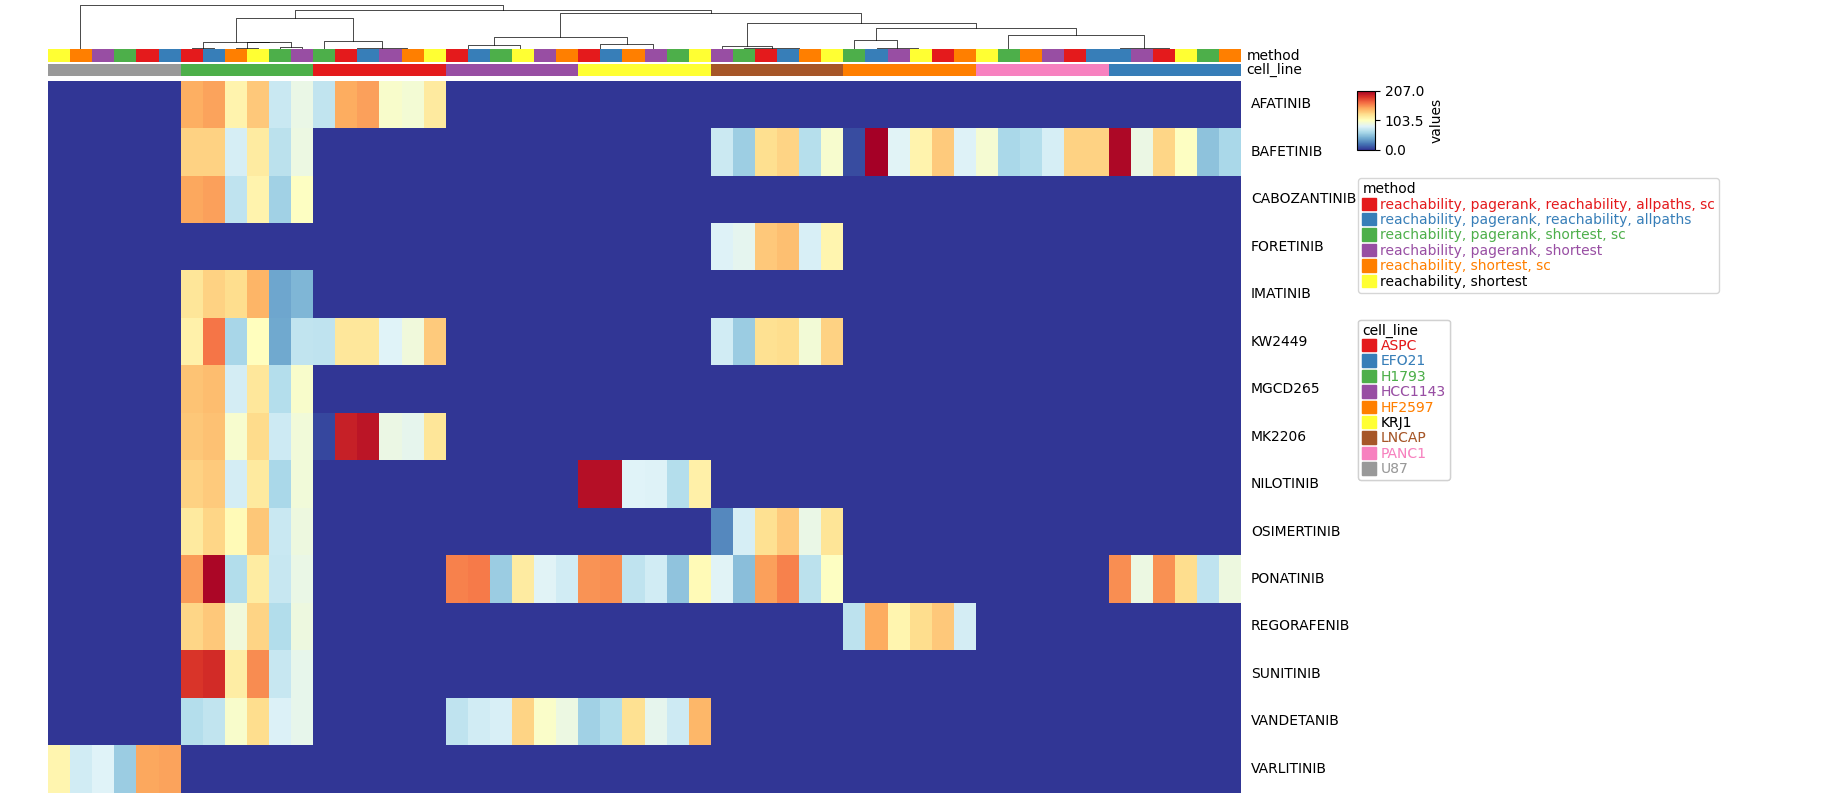

In [35]:
plt.figure(figsize=(16, 9))
# create heatmap annotation for cell line

cm = ClusterMapPlotter(data=nodes_df,
                       top_annotation=col_ha,
                       col_cluster=True,row_cluster=False,
                       label='values',row_dendrogram=True,
                       col_dendrogram=True,
                       show_rownames=True,show_colnames=False,
                       tree_kws={'row_cmap': 'Set1'},verbose=0,
                       legend=True,
                       
                       cmap='RdYlBu_r',xticklabels_kws={'labelrotation':-90,'labelcolor':'blue'})
plt.show()